In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mse
import os
from pathlib import Path
import pandas as pd
import seaborn as sns

데이터(이미지 수집) - 여객선, 컨테이너선, 전용선, 어선, 특수선, 군함

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_ = Path('/content/drive/MyDrive/Ship')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Ship/Ferry/ferry382.jpg,Ferry
1,/content/drive/MyDrive/Ship/Special Ship/Speci...,Special Ship
2,/content/drive/MyDrive/Ship/Ferry/ferry591.jpg,Ferry
3,/content/drive/MyDrive/Ship/Special Ship/Speci...,Special Ship
4,/content/drive/MyDrive/Ship/Container Carrier/...,Container Carrier


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 2234

Number of different labels: 6

Labels: ['Ferry' 'Special Ship' 'Container Carrier' 'Fishing Boat' 'War Ship'
 'Bulk Carrier']


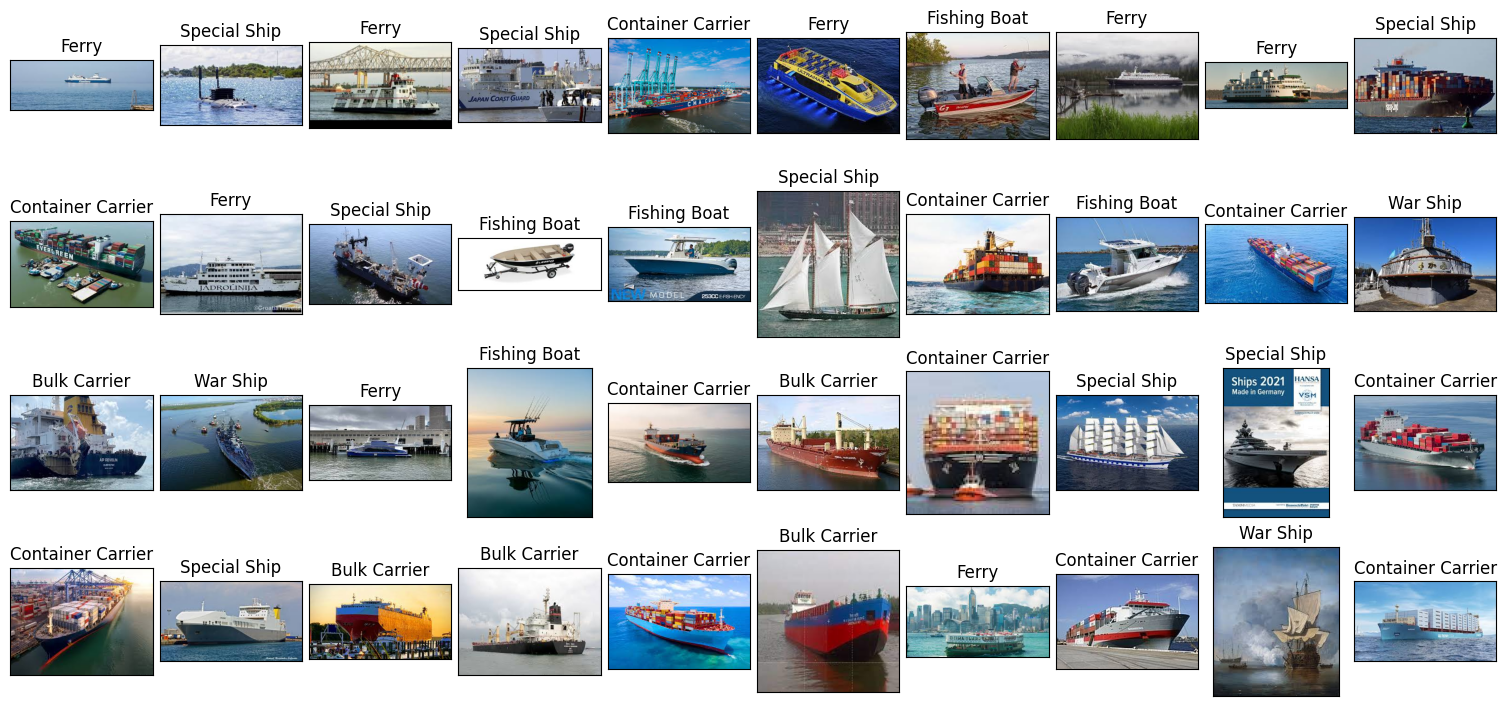

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

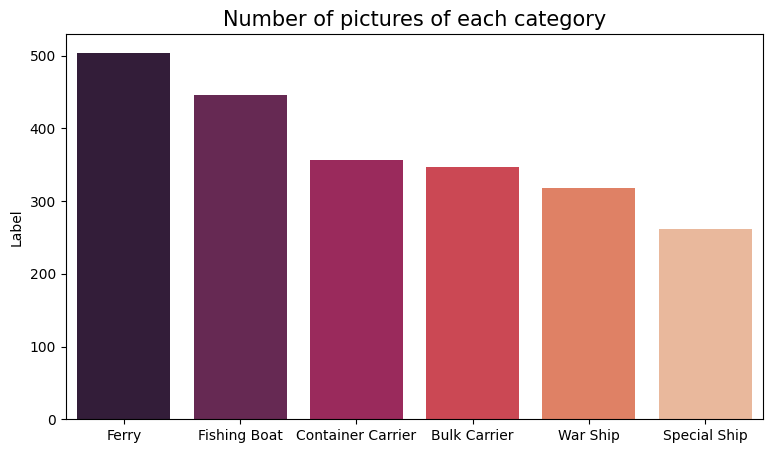

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df.shape, test_df.shape

((1787, 2), (447, 2))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical', subset='training')
val_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical', subset='validation')

Found 1790 images belonging to 6 classes.
Found 444 images belonging to 6 classes.


CNN 데이터 학습 및 예측

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
# (150, 150, 3)의 데이터를 입력으로 받습니다.
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(6, activation = 'softmax')) # 열 개의 출력을 가지는 신경망

model.compile(optimizer = Adam(1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                    

In [ ]:
history = model.fit(x = train_generator,
                    epochs = 30,
                    batch_size = 32,
                    validation_data = val_generator)

Epoch 1/30
56/56 [==============================] - 818s 15s/step - loss: 1.7531 - acc: 0.2358 - val_loss: 1.7292 - val_acc: 0.2500
Epoch 2/30
56/56 [==============================] - 5s 90ms/step - loss: 1.6693 - acc: 0.3056 - val_loss: 1.6416 - val_acc: 0.3468
Epoch 3/30
56/56 [==============================] - 5s 91ms/step - loss: 1.5580 - acc: 0.3793 - val_loss: 1.5353 - val_acc: 0.3896
Epoch 4/30
56/56 [==============================] - 6s 109ms/step - loss: 1.4219 - acc: 0.4480 - val_loss: 1.5586 - val_acc: 0.3919
Epoch 5/30
56/56 [==============================] - 5s 93ms/step - loss: 1.3289 - acc: 0.4810 - val_loss: 1.5202 - val_acc: 0.4437
Epoch 6/30
56/56 [==============================] - 6s 98ms/step - loss: 1.1968 - acc: 0.5480 - val_loss: 1.4569 - val_acc: 0.4685
Epoch 7/30
56/56 [==============================] - 6s 110ms/step - loss: 1.0818 - acc: 0.6039 - val_loss: 1.4929 - val_acc: 0.4505
Epoch 8/30
56/56 [==============================] - 5s 90ms/step - loss: 0.9203 

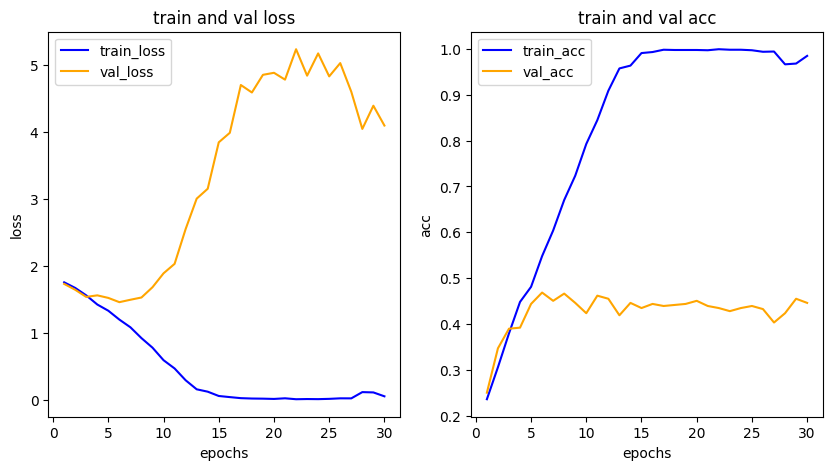

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

이미지 증식 학습 및 예측

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df.shape, test_df.shape

((1787, 2), (447, 2))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

# 검증 데이터셋에는 변환을 사용하지 않습니다.
# val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical', subset='training')
val_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical', subset='validation')

Found 1790 images belonging to 6 classes.
Found 444 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
# (150, 150, 3)의 데이터를 입력으로 받습니다.
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(6, activation = 'softmax')) # 열 개의 출력을 가지는 신경망

model.compile(optimizer = Adam(1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 38, 38, 64)       0         
 g2D)                                                 

In [ ]:
def get_step(train_len, batch_size):
    if(train_len % batch_size > 0):
        return train_len // batch_size + 1
    else:
        return train_len // batch_size

In [ ]:
batch_size = 32

history = model.fit(x = train_generator,
                    epochs = 30,
                    steps_per_epoch = get_step(len(train_df), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_step(len(test_df), batch_size))

Epoch 1/30
56/56 [==============================] - 21s 325ms/step - loss: 1.7720 - acc: 0.2067 - val_loss: 1.7531 - val_acc: 0.2050
Epoch 2/30
56/56 [==============================] - 20s 362ms/step - loss: 1.7362 - acc: 0.2469 - val_loss: 1.6478 - val_acc: 0.2748
Epoch 3/30
56/56 [==============================] - 20s 351ms/step - loss: 1.6340 - acc: 0.3279 - val_loss: 1.5381 - val_acc: 0.3694
Epoch 4/30
56/56 [==============================] - 18s 319ms/step - loss: 1.5783 - acc: 0.3603 - val_loss: 1.4912 - val_acc: 0.3784
Epoch 5/30
56/56 [==============================] - 18s 319ms/step - loss: 1.5067 - acc: 0.4028 - val_loss: 1.3952 - val_acc: 0.4640
Epoch 6/30
56/56 [==============================] - 18s 329ms/step - loss: 1.4794 - acc: 0.4073 - val_loss: 1.3988 - val_acc: 0.4617
Epoch 7/30
56/56 [==============================] - 20s 364ms/step - loss: 1.4403 - acc: 0.4285 - val_loss: 1.4209 - val_acc: 0.4234
Epoch 8/30
56/56 [==============================] - 18s 325ms/step - 

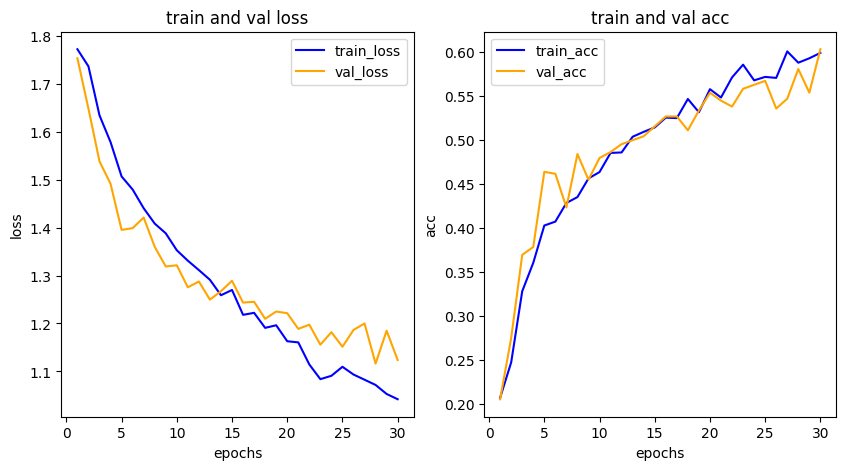

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

전이 학습법을 이용하여 학습 및 예측

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
#        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
 #       shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
from time import perf_counter

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

     # 전이 학습 모델 가져오기
     m = get_model(model['model'])
     models[name]['model'] = m

     start = perf_counter()

     # 모델 학습
     history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

     # 학습시간과 val_accuracy 저장
     duration = perf_counter() - start
     duration = round(duration,2)
     models[name]['perf'] = duration
     print(f"{name:20} trained in {duration} sec")

     val_acc = history.history['val_accuracy']
     models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1430 validated image filenames belonging to 6 classes.
Found 357 validated image filenames belonging to 6 classes.
Found 447 validated image filenames belonging to 6 classes.


DenseNet121          trained in 22.34 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 25.88 sec
74836368/74836368 [==============================] - 3s 0us/step
DenseNet201          trained in 30.66 sec
16705208/16705208 [==============================] - 1s 0us/step
EfficientNetB0       trained in 15.92 sec
27018416/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 19.41 sec
87910968/87910968 [==============================] - 3s 0us/step
InceptionV3          trained in 18.58 sec
12683000/12683000 [==============================] - 1s 0us/step
MobileNetV3Large     trained in 12.85 sec
234545216/234545216 [==============================] - 7s 0us/step
ResNet152V2          trained in 30.59 sec
94765736/94765736 [=======

In [ ]:
from sklearn.metrics import accuracy_score

# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

14/14 [==============================] - 2s 160ms/step
**DenseNet121 has a 73.60% accuracy on the test set**
14/14 [==============================] - 3s 153ms/step
**MobileNetV2 has a 72.48% accuracy on the test set**
14/14 [==============================] - 8s 325ms/step
**DenseNet201 has a 75.84% accuracy on the test set**
14/14 [==============================] - 3s 137ms/step
**EfficientNetB0 has a 20.81% accuracy on the test set**
14/14 [==============================] - 4s 113ms/step
**EfficientNetB1 has a 21.25% accuracy on the test set**
14/14 [==============================] - 6s 334ms/step
**InceptionV3 has a 65.32% accuracy on the test set**
14/14 [==============================] - 3s 133ms/step
**MobileNetV3Large has a 29.98% accuracy on the test set**
14/14 [==============================] - 7s 350ms/step
**ResNet152V2 has a 74.05% accuracy on the test set**
14/14 [==============================] - 4s 192ms/step
**ResNet50 has a 34.45% accuracy on the test set**
14/14 [====

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.7899,0.7584,30.66
1,ResNet152V2,0.7479,0.7405,30.59
2,ResNet50V2,0.7227,0.7383,11.93
3,DenseNet121,0.7031,0.7360,22.34
4,MobileNetV2,0.6947,0.7248,25.88
5,Xception,0.7199,0.7136,15.88
6,InceptionV3,0.7143,0.6532,18.58
7,VGG16,0.5378,0.5324,11.17
8,VGG19,0.3725,0.3803,23.86
9,ResNet50,0.3333,0.3445,14.39


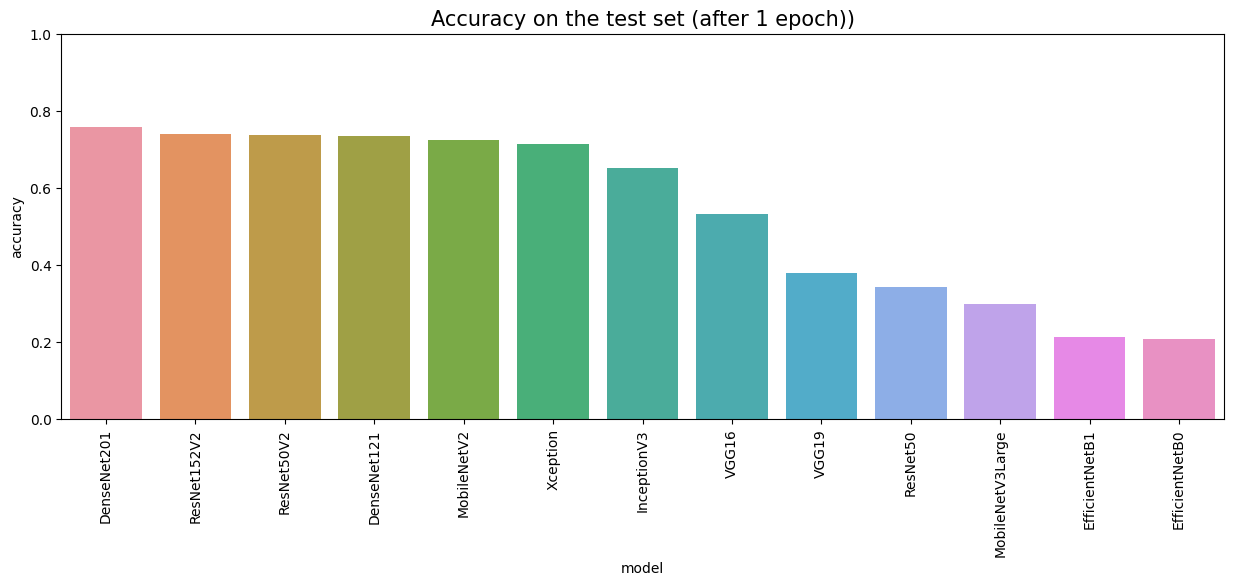

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

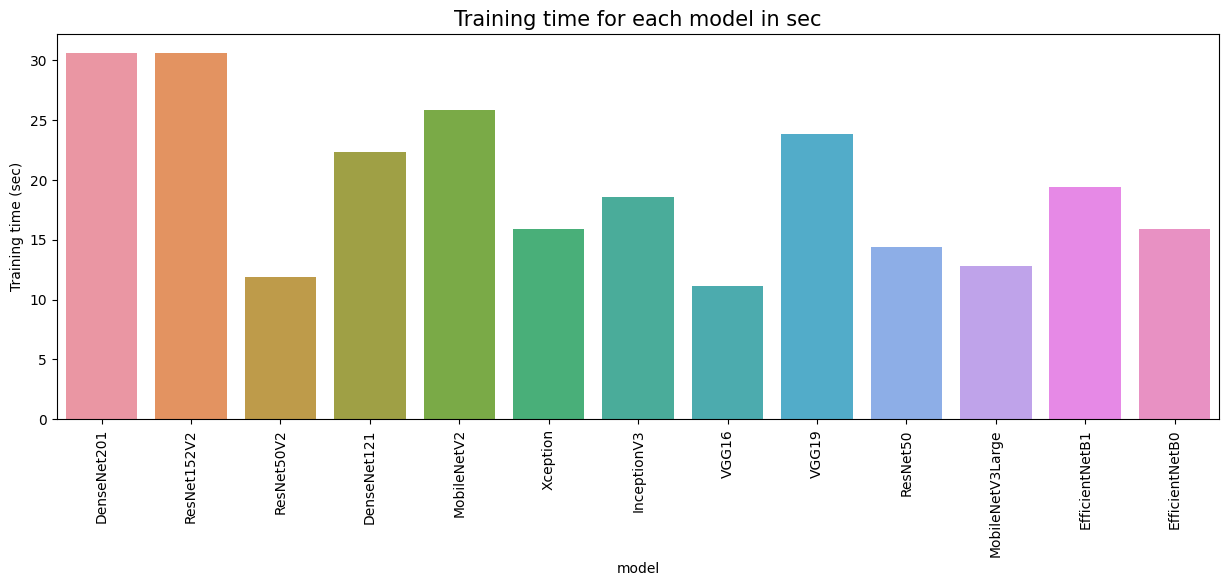

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

DenseNet201을 이용한 전이 학습

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.2, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 1430 validated image filenames belonging to 6 classes.
Found 357 validated image filenames belonging to 6 classes.
Found 447 validated image filenames belonging to 6 classes.
Epoch 1/10
45/45 [==============================] - 31s 307ms/step - loss: 1.0245 - accuracy: 0.6490 - val_loss: 0.6530 - val_accuracy: 0.7563
Epoch 2/10
45/45 [==============================] - 10s 222ms/step - loss: 0.5809 - accuracy: 0.7944 - val_loss: 0.6085 - val_accuracy: 0.7675
Epoch 3/10
45/45 [==============================] - 10s 213ms/step - loss: 0.4502 - accuracy: 0.8371 - val_loss: 0.6434 - val_accuracy: 0.7843
Epoch 4/10
45/45 [==============================] - 10s 232ms/step - loss: 0.3533 - accuracy: 0.8839 - val_loss: 0.5862 - val_accuracy: 0.8011
Epoch 5/10
45/45 [==============================] - 14s 308ms/step - loss: 0.2919 - accuracy: 0.9056 - val_loss: 0.5984 - val_accuracy: 0.7955
Epoch 6/10
45/45 [==============================] - 9s 200ms/step - loss: 0.2199 - accuracy: 0.9364 - va

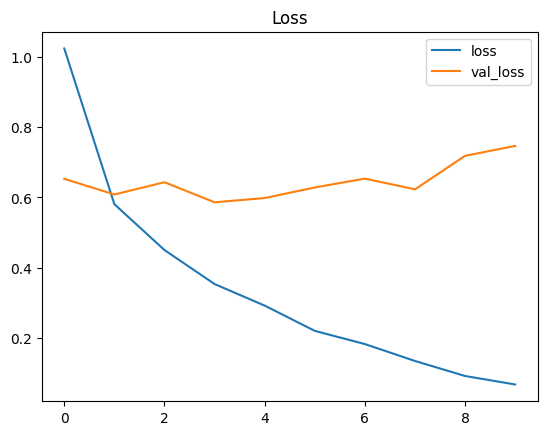

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

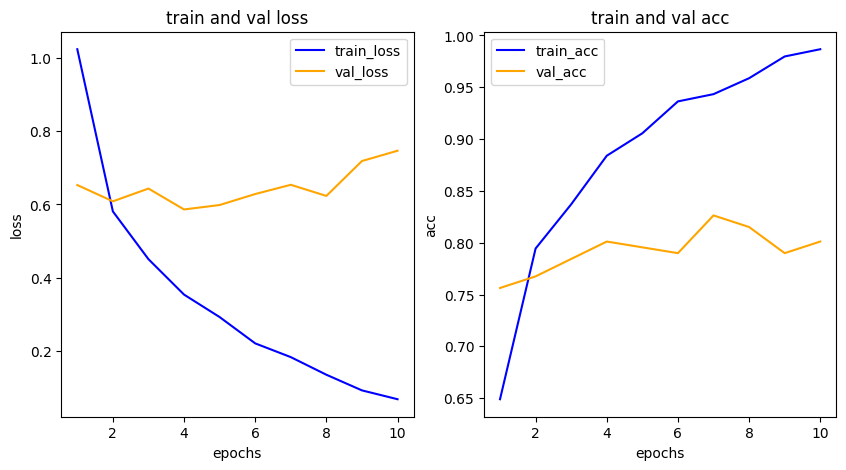

In [ ]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

14/14 [==============================] - 5s 149ms/step
Accuracy on the test set: 80.31%


결과 비교 (시각화)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1. / 255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale = 1. / 255)
# 이미지 픽셀을 0에서 1사이의 값으로 스케일을 조정한다.

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical', subset='training')

Found 1790 images belonging to 6 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Ship',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical', subset='validation')

Found 444 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'Bulk Carrier': 0,
 'Container Carrier': 1,
 'Ferry': 2,
 'Fishing Boat': 3,
 'Special Ship': 4,
 'War Ship': 5}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(filters = 75, kernel_size = 3, padding = 'same', input_shape = (150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 75, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 150, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 150, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 220, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 220, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

model.compile(optimizer = Adam(1e-4),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182 (Conv2D)         (None, 150, 150, 75)      2100      
                                                                 
 batch_normalization_143 (Ba  (None, 150, 150, 75)     300       
 tchNormalization)                                               
                                                                 
 activation_139 (Activation)  (None, 150, 150, 75)     0         
                                                                 
 conv2d_183 (Conv2D)         (None, 150, 150, 75)      50700     
                                                                 
 batch_normalization_144 (Ba  (None, 150, 150, 75)     300       
 tchNormalization)                                               
                                                                 
 activation_140 (Activation)  (None, 150, 150, 75)   

In [ ]:
def get_step(train_len, batch_size):
  if(train_len % batch_size > 0):
    return train_len // batch_size + 1
  else:
    return train_len // batch_size

In [ ]:
history = model.fit(x = train_generator,
                    steps_per_epoch = get_step(len(train_df), 32),
                    epochs = 30,
                    validation_data = val_generator)

Epoch 1/30
56/56 [==============================] - 17s 297ms/step - loss: 0.4224 - acc: 0.3391 - val_loss: 0.5686 - val_acc: 0.1419
Epoch 2/30
56/56 [==============================] - 17s 303ms/step - loss: 0.3926 - acc: 0.4330 - val_loss: 0.5492 - val_acc: 0.1419
Epoch 3/30
56/56 [==============================] - 17s 301ms/step - loss: 0.3742 - acc: 0.4665 - val_loss: 0.5688 - val_acc: 0.1419
Epoch 4/30
56/56 [==============================] - 17s 302ms/step - loss: 0.3524 - acc: 0.5078 - val_loss: 0.6033 - val_acc: 0.1419
Epoch 5/30
56/56 [==============================] - 17s 300ms/step - loss: 0.3357 - acc: 0.5324 - val_loss: 0.6150 - val_acc: 0.1419
Epoch 6/30
56/56 [==============================] - 17s 298ms/step - loss: 0.3255 - acc: 0.5615 - val_loss: 0.6163 - val_acc: 0.1509
Epoch 7/30
56/56 [==============================] - 18s 312ms/step - loss: 0.3172 - acc: 0.5810 - val_loss: 0.5701 - val_acc: 0.1914
Epoch 8/30
56/56 [==============================] - 17s 301ms/step - 

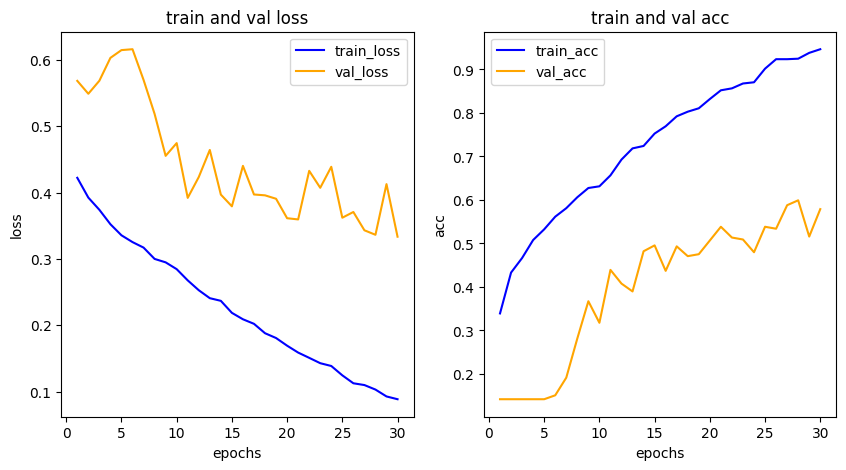

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras.utils as image
import matplotlib.pyplot as plt

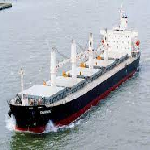

In [ ]:
img=image.load_img('/content/drive/MyDrive/Ship/Bulk Carrier/bulk carrier0.jpg',
                   target_size=(150,150))
img

In [ ]:
x=image.img_to_array(img) / 255
print('전:',x.shape)
images = np.expand_dims(x, axis=0)
print('후:', images.shape)

전: (150, 150, 3)
후: (1, 150, 150, 3)


In [ ]:
classes = model.predict(images, batch_size=10)
classes

1/1 [==============================] - 1s 525ms/step


array([[0.98429537, 0.01181407, 0.02168827, 0.00874066, 0.01570653,
        0.00688546]], dtype=float32)

In [ ]:
print(classes[0])

[0.98429537 0.01181407 0.02168827 0.00874066 0.01570653 0.00688546]


In [ ]:
def pred(fname):
    img=image.load_img(fname, target_size=(150,150))
    plt.imshow(img)

    x=image.img_to_array(img)/255
    images = np.expand_dims(x, axis=0)

    classes = model.predict(images, batch_size=10)

    print(classes[0])

    if classes[0][0] > 0.5:
        print(fname.split('/')[-1] + '사진은 전용선입니다.')
    elif classes[0][1] > 0.5:
        print(fname.split('/')[-1] + '사진은 컨테이너선입니다.')
    elif classes[0][2] > 0.5:
        print(fname.split('/')[-1] + '사진은 여객선입니다.')
    elif classes[0][3] > 0.5:
        print(fname.split('/')[-1] + '사진은 어선입니다.')
    elif classes[0][4] > 0.5:
        print(fname.split('/')[-1] + '사진은 특수선입니다.')
    elif classes[0][5] > 0.5:
        print(fname.split('/')[-1] + '사진은 군함입니다.')

In [ ]:
files.upload()

{}

1/1 [==============================] - 0s 20ms/step
[0.11903403 0.00361697 0.00571813 0.00391373 0.04998713 0.8958021 ]
War Ship8.jpg사진은 군함입니다.


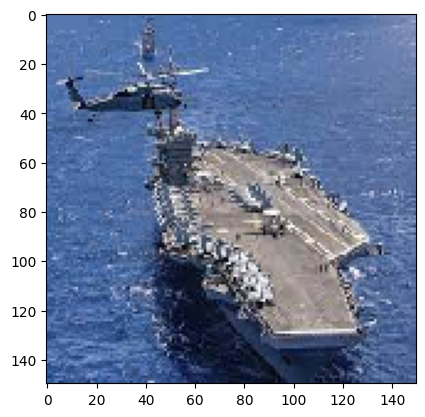

In [ ]:
pred('/content/drive/MyDrive/Ship/War Ship/War Ship8.jpg')

In [ ]:
files.upload()

Saving ferry9.jpg to ferry9.jpg


{'ferry9.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x07\x08\x16\x15\x15\x18\x16\x15\x16\x18\x18\x18\x18\x18\x1a\x1c\x1a\x1c\x1a\x18\x18\x1a\x19\x1c\x18\x19\x18\x1a\x19\x1c\x1a\x18\x19\x1c$.%\x1c\x1e+\x1f\x19\x18&8&+/4555\x1a$;@;3?.451\x01\x0c\x0c\x0c\x10\x0f\x10\x1a\x12\x12\x1a1!$!4444111444144144111444446444441414154444?444415141\xff\xc0\x00\x11\x08\x00\xa8\x01+\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\xff\xc4\x00H\x10\x00\x01\x03\x01\x05\x05\x05\x04\x06\x08\x04\x04\x07\x00\x00\x00\x01\x00\x02\x11!\x03\x04\x121AQaq\x81\x91\x05\x06\x13\xa1\xf0"2\xb1\xc1\x07\x14Br\xb2\xd1Rb\x82\x92\xc2\xd2\xe1\xf1CD\x93\xa2\x15\x17#3\x16T\x83\x84\xb3\xc3\xe2\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00"\x11\x01\x00\x02\x02\x02\x02\x02\x03\x01\x00\x00\x00\x00\x00\x0

1/1 [==============================] - 0s 38ms/step
[2.3032879e-03 2.9865763e-05 8.9273864e-01 9.1911480e-02 9.3633257e-02
 6.7885849e-03]
ferry9.jpg사진은 여객선입니다.


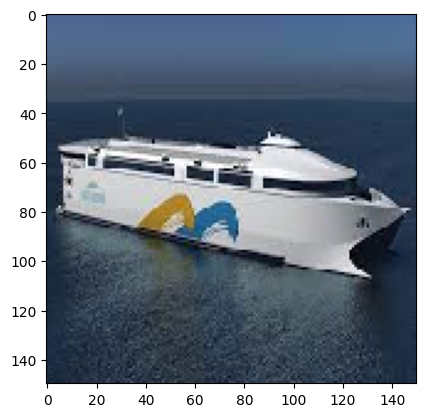

In [ ]:
pred('/content/drive/MyDrive/Ship/Ferry/ferry9.jpg')

In [ ]:
files.upload()

Saving Fishing Boat20.jpg to Fishing Boat20.jpg


{'Fishing Boat20.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x10\x10\x10\x15\x10\x12\x10\x15\x15\x15\x17\x16\x17\x15\x15\x17\x18\x17\x16\x16\x16\x15\x17\x16\x18\x16\x18\x17\x18\x17\x18\x1b\x1d( \x18\x1a%\x1e\x15\x17!1"%)+...\x18\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1b-%\x1f\x1f-------+------------------------------------------\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00J\x10\x00\x01\x03\x02\x03\x04\x07\x04\x03\x0e\x05\x02\x07\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121\x05"AQ\x06\x13aq\x81\x91\xa12\xb1\xc1\xd1\x14B\xf0\x07\x15#RTbr\x92\x93\xa2\xb2\xd2\xd3\xe13CS\x82\xf1$4\x16\x17s\x83\xa3\xc3\xe2\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00!\x11\x01\x01\x00\x02\x01\x05\x01\x01\x01\x01\

1/1 [==============================] - 0s 98ms/step
[0.05542406 0.00352557 0.09725327 0.6362996  0.06125803 0.05577715]
Fishing Boat20.jpg사진은 어선입니다.


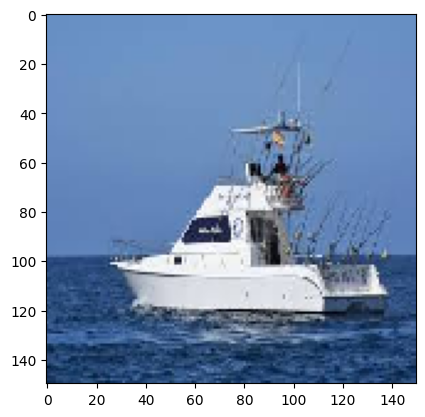

In [ ]:
pred('/content/drive/MyDrive/Ship/Fishing Boat/Fishing Boat20.jpg')